# Fine-Tuning BERT for Named Entity Recognition (NER)
## ZAMEER KHAN
### 23565018

## 1. Introduction

This notebook demonstrates the process of fine-tuning a pre-trained BERT model for Named Entity Recognition (NER) using the CoNLL-2003 dataset. The goal is to create a robust NER model that can accurately identify and classify entities within text.

## 2. Setup and Installation

In [125]:
#!pip install datasets
#!pip install accelerate -U 
# improve the efficiency of model training by leveraging various hardware accelerators such as GPUs and TPUs

### Import Libraries

In [15]:
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizerFast
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import logging as hf_logging
from transformers import pipeline
from seqeval.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import json

hf_logging.set_verbosity_info() #to display informational messages.

In [16]:
from transformers import AutoModelForTokenClassification

In [17]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

## 3. Data Exploration (EDA)

### Load Dataset

In [18]:
conll2003 = datasets.load_dataset("conll2003", trust_remote_code=True)
conll2003
#Part-of-speech tagging involves assigning a label to each word[Noun/Verb/Adjective]
#chunk_tags-labeling multi-token sequences in a sentence. It groups words into meaningful chunks.[Noun Phrase]

Using the latest cached version of the module from /Users/zameerkhan/.cache/huggingface/modules/datasets_modules/datasets/conll2003/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98 (last modified on Sun May 19 21:30:10 2024) since it couldn't be found locally at conll2003, or remotely on the Hugging Face Hub.


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

### Convert to DataFrame

In [19]:
train_df = pd.DataFrame(conll2003['train'])
validation_df = pd.DataFrame(conll2003['validation'])
test_df = pd.DataFrame(conll2003['test'])

### Data Overview

In [20]:
print(train_df.head())
print(f"Number of sentences in the training set: {len(train_df)}")
print(f"Number of sentences in the validation set: {len(validation_df)}")
print(f"Number of sentences in the test set: {len(test_df)}")

  id                                             tokens  \
0  0  [EU, rejects, German, call, to, boycott, Briti...   
1  1                                 [Peter, Blackburn]   
2  2                             [BRUSSELS, 1996-08-22]   
3  3  [The, European, Commission, said, on, Thursday...   
4  4  [Germany, 's, representative, to, the, Europea...   

                                            pos_tags  \
0                [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                           [22, 22]   
2                                           [22, 11]   
3  [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4  [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   

                                          chunk_tags  \
0                [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                           [11, 12]   
2                                           [11, 12]   
3  [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4  [11, 11, 12, 13, 11, 12, 

In [21]:
label_list = conll2003["train"].features["ner_tags"].feature.names
print(label_list)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


### Distribution of Sentence Lengths

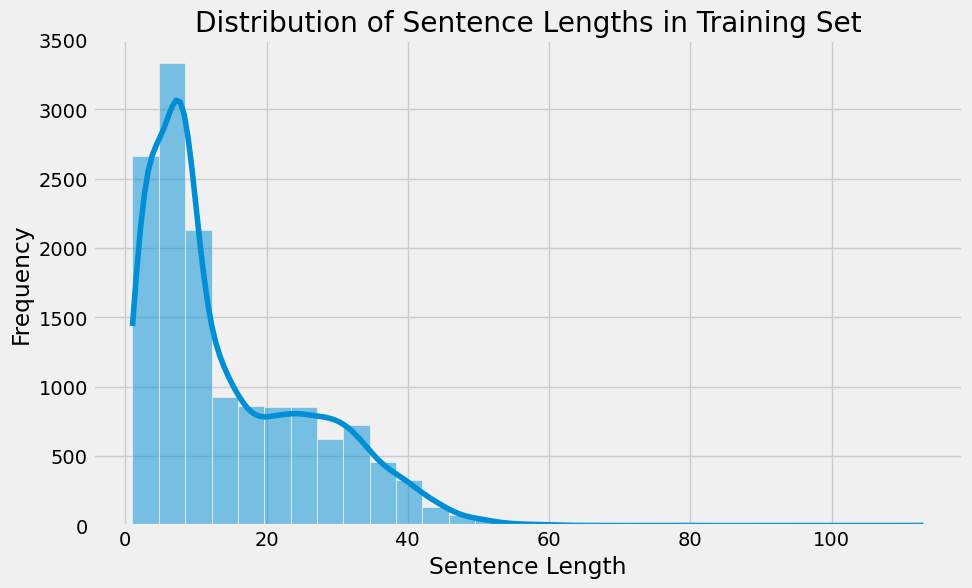

In [22]:
train_df['sentence_length'] = train_df['tokens'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sentence_length'], bins=30, kde=True)
plt.title('Distribution of Sentence Lengths in Training Set')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

### Distribution of Named Entity Tags

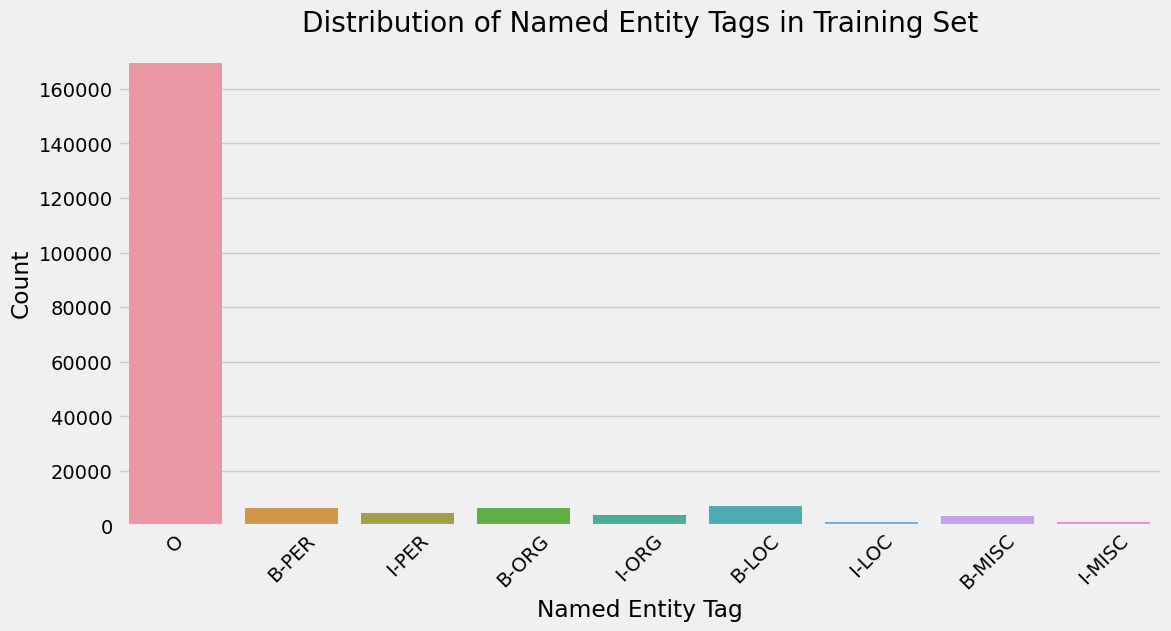

In [23]:
ner_tags = conll2003['train'].features['ner_tags'].feature.names
tag_counts = [0] * len(ner_tags)
for tags in train_df['ner_tags']:
    for tag in tags:
        tag_counts[tag] += 1

plt.figure(figsize=(12, 6))
sns.barplot(x=ner_tags, y=tag_counts)
plt.title('Distribution of Named Entity Tags in Training Set')
plt.xlabel('Named Entity Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 4. Data Preparation

### Tokenization and Label Alignment

In [24]:
#load a pre-trained tokenizer.
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

loading file vocab.txt from cache at /Users/zameerkhan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file tokenizer.json from cache at /Users/zameerkhan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/zameerkhan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading configuration file config.json from cache at /Users/zameerkhan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,

In [25]:
example_1 = conll2003['train'][0]
tokenized_input = tokenizer(example_1["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
word_ids = tokenized_input.word_ids()
print("word_ids :: ",word_ids)
''' As we can see, it returns a list with the same number of elements as our processed input ids, 
    mapping special tokens to None and all other tokens to their respective word.'''
print()
print("tokenized_input :: ",tokenized_input)

word_ids ::  [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]

tokenized_input ::  {'input_ids': [101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [26]:
len(example_1['ner_tags']), len(tokenized_input["input_ids"])

(9, 11)

In [79]:
#Function to tokenize and align labels with respect to the tokens.
def tokenize_and_align_labels(examples, label_all_tokens=True):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [80]:
tokenized_datasets = conll2003.map(tokenize_and_align_labels, batched=True)

In [81]:
q = tokenize_and_align_labels(conll2003['train'][3:4])
print(q)

{'input_ids': [[101, 1996, 2647, 3222, 2056, 2006, 9432, 2009, 18335, 2007, 2446, 6040, 2000, 10390, 2000, 18454, 2078, 2329, 12559, 2127, 6529, 5646, 3251, 5506, 11190, 4295, 2064, 2022, 11860, 2000, 8351, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]]}


In [82]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q["input_ids"][0]),q["labels"][0]):
    print(f"{token:_<40} {label}")

[CLS]___________________________________ -100
the_____________________________________ 0
european________________________________ 3
commission______________________________ 4
said____________________________________ 0
on______________________________________ 0
thursday________________________________ 0
it______________________________________ 0
disagreed_______________________________ 0
with____________________________________ 0
german__________________________________ 7
advice__________________________________ 0
to______________________________________ 0
consumers_______________________________ 0
to______________________________________ 0
shu_____________________________________ 0
##n_____________________________________ 0
british_________________________________ 7
lamb____________________________________ 0
until___________________________________ 0
scientists______________________________ 0
determine_______________________________ 0
whether_________________________________ 0
mad_____

## 5. Model Fine-Tuning

### Load Pre-trained Model

In [83]:
try:
    model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(conll2003['train'].features['ner_tags'].feature.names))
    print("Model loaded successfully")
except Exception as e:
    # Print the exception if there is an error
    print(f"Error loading model: {e}")

loading configuration file config.json from cache at /Users/zameerkhan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert"

Model loaded successfully


In [84]:
data_collator = DataCollatorForTokenClassification(tokenizer)
#Batch Creation, Dynamic Padding, Attention Masks
metric = datasets.load_metric("seqeval",trust_remote_code=True)

In [85]:
#Define early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience = 2  #Number of epochs to wait for improvement
)

### Define Training Arguments

In [86]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=3,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


### Metrics Calculation

In [87]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### Initialize Trainer with EarlyStoppingCallback

In [89]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [90]:
train_result = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, chunk_tags, pos_tags, tokens, ner_tags. If id, chunk_tags, pos_tags, tokens, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14,041
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8,780
  Number of trainable parameters = 108,898,569


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.082800,0.065088,0.909011,0.924264,0.916574,0.981715
2,0.022100,0.061149,0.939104,0.945408,0.942246,0.985925
3,0.021000,0.059815,0.940686,0.945632,0.943152,0.986560
4,0.018700,0.069447,0.934643,0.947086,0.940823,0.985718
5,0.015600,0.070005,0.936518,0.947310,0.941883,0.986084


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, chunk_tags, pos_tags, tokens, ner_tags. If id, chunk_tags, pos_tags, tokens, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-878
Configuration saved in ./results/checkpoint-878/config.json
Model weights saved in ./results/checkpoint-878/model.safetensors
tokenizer config file saved in ./results/checkpoint-878/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-878/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-2634] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, chunk_tags, pos_tags, tokens, ner_tags.

In [91]:
model.save_pretrained("ner_model")
tokenizer.save_pretrained("tokenizer")

Configuration saved in ner_model/config.json
Model weights saved in ner_model/model.safetensors
tokenizer config file saved in tokenizer/tokenizer_config.json
Special tokens file saved in tokenizer/special_tokens_map.json


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [92]:
id2label = {
    str(i): label for i,label in enumerate(label_list)
}
label2id = {
    label: str(i) for i,label in enumerate(label_list)
}

In [93]:
config = json.load(open("ner_model/config.json"))
config["id2label"] = id2label
config["label2id"] = label2id
json.dump(config, open("ner_model/config.json","w"))

## 6. Visualization of Training Process

### Training and Evaluation Loss Curves

In [94]:
eval_results = trainer.evaluate()
print(f"Evaluation results :: {eval_results}")

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, chunk_tags, pos_tags, tokens, ner_tags. If id, chunk_tags, pos_tags, tokens, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 16


Evaluation results :: {'eval_loss': 0.059814952313899994, 'eval_precision': 0.9406855107945693, 'eval_recall': 0.9456315024051908, 'eval_f1': 0.9431520223152023, 'eval_accuracy': 0.9865601220074031, 'eval_runtime': 12.1126, 'eval_samples_per_second': 268.316, 'eval_steps_per_second': 16.842, 'epoch': 5.0}


In [95]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
            [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
]

true_labels = [
            [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
]
results = metric.compute(predictions=true_predictions, references=true_labels)
results

The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, chunk_tags, pos_tags, tokens, ner_tags. If id, chunk_tags, pos_tags, tokens, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3453
  Batch size = 16


{'LOC': {'precision': 0.8774165202108963,
  'recall': 0.9402071563088512,
  'f1': 0.9077272727272728,
  'number': 2124},
 'MISC': {'precision': 0.8140589569160998,
  'recall': 0.7208835341365462,
  'f1': 0.7646432374866879,
  'number': 996},
 'ORG': {'precision': 0.8747598924318094,
  'recall': 0.8798299845440495,
  'f1': 0.8772876131766519,
  'number': 2588},
 'PER': {'precision': 0.966321243523316,
  'recall': 0.9606328182487123,
  'f1': 0.9634686346863469,
  'number': 2718},
 'overall_precision': 0.8983811887037694,
 'overall_recall': 0.9023261333966295,
 'overall_f1': 0.900349339806975,
 'overall_accuracy': 0.9770216145293833}

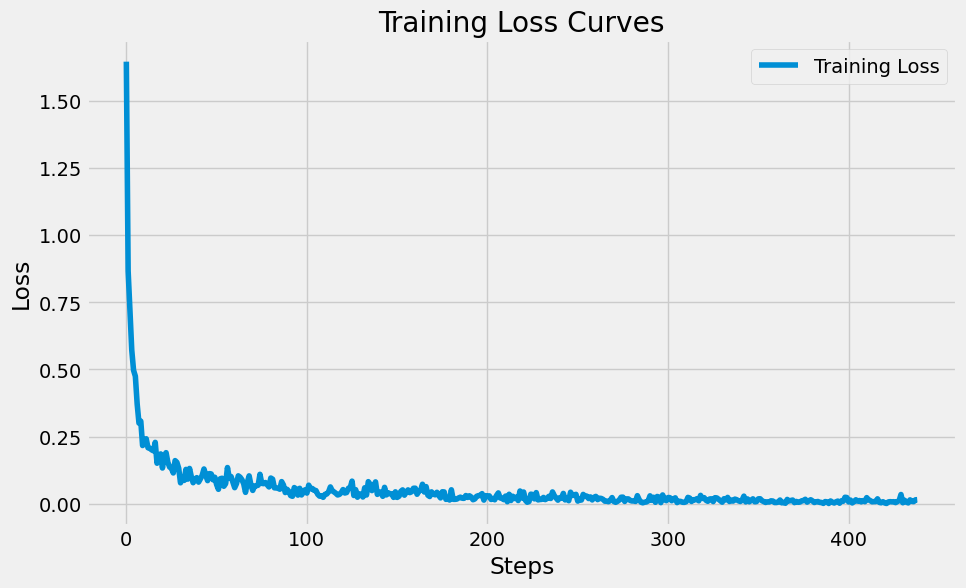

In [117]:
train_losses = []

# Extract training losses from log history
for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()


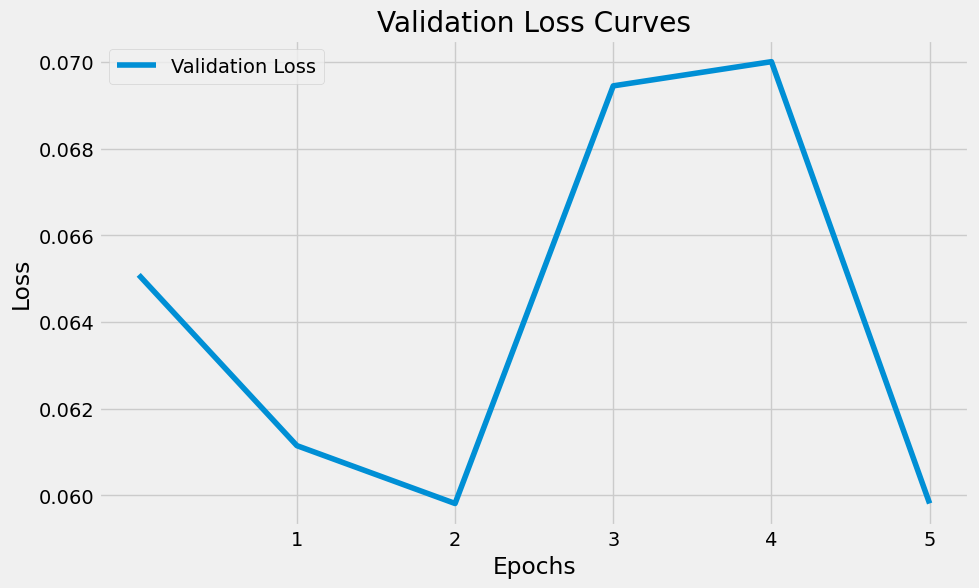

In [118]:

eval_losses = [] 
        
for log in trainer.state.log_history:
    # Check if the log contains validation loss information
    if 'eval_loss' in log:
        # Append the validation loss to the list
        eval_losses.append(log['eval_loss'])        


# Plot Validation losses
plt.figure(figsize=(10, 6))
plt.plot(eval_losses[0:6], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Curves')
plt.legend()
plt.xticks(range(1, 6))
plt.show()


### Test the Model with Example Texts

In [8]:
from transformers import AutoModelForTokenClassification
from transformers import pipeline #provides an easy-to-use interface for performing NLP tasks using pre-trained models
from transformers import BertTokenizerFast

In [9]:
model= AutoModelForTokenClassification.from_pretrained("ner_model")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

In [11]:
text = "Steve Jobs  is the Founder of Apple."
ner_results = nlp(text)
print(ner_results)

[{'entity': 'B-PER', 'score': 0.9980292, 'index': 1, 'word': 'steve', 'start': 0, 'end': 5}, {'entity': 'I-PER', 'score': 0.9950257, 'index': 2, 'word': 'jobs', 'start': 6, 'end': 10}, {'entity': 'B-ORG', 'score': 0.99140114, 'index': 7, 'word': 'apple', 'start': 30, 'end': 35}]


In [12]:
text = "Shortage of Jobs in India."
ner_results = nlp(text)
print(ner_results)

[{'entity': 'B-LOC', 'score': 0.99848396, 'index': 5, 'word': 'india', 'start': 20, 'end': 25}]


In [13]:
text = "London, the capital of England and the United Kingdom, is a 21st-century city with history \
         stretching back to Roman times"
ner_results = nlp(text)

print(ner_results)

[{'entity': 'B-LOC', 'score': 0.99344504, 'index': 1, 'word': 'london', 'start': 0, 'end': 6}, {'entity': 'B-LOC', 'score': 0.99817646, 'index': 6, 'word': 'england', 'start': 23, 'end': 30}, {'entity': 'B-LOC', 'score': 0.9954366, 'index': 9, 'word': 'united', 'start': 39, 'end': 45}, {'entity': 'I-LOC', 'score': 0.995697, 'index': 10, 'word': 'kingdom', 'start': 46, 'end': 53}, {'entity': 'B-MISC', 'score': 0.8960516, 'index': 23, 'word': 'roman', 'start': 119, 'end': 124}]


In [14]:
text = "Delhi, India’s capital territory, is a massive metropolitan area in the country’s north. \
        In Old Delhi, a neighborhood dating to the 1600s, stands the imposing Red Fort."
ner_results = nlp(text)

print(ner_results)

[{'entity': 'B-LOC', 'score': 0.99597377, 'index': 1, 'word': 'delhi', 'start': 0, 'end': 5}, {'entity': 'B-LOC', 'score': 0.99769396, 'index': 3, 'word': 'india', 'start': 7, 'end': 12}, {'entity': 'B-LOC', 'score': 0.89606684, 'index': 22, 'word': 'old', 'start': 100, 'end': 103}, {'entity': 'I-LOC', 'score': 0.5787895, 'index': 23, 'word': 'delhi', 'start': 104, 'end': 109}, {'entity': 'B-LOC', 'score': 0.5281678, 'index': 36, 'word': 'red', 'start': 167, 'end': 170}]
